<a href="https://colab.research.google.com/github/muhlokend/Project1/blob/main/Survived_inTitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving titanic_test.csv to titanic_test.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


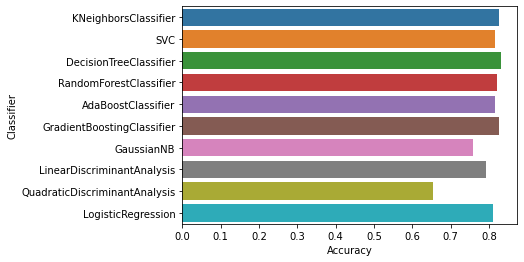

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Making DataFrame
df = pd.read_csv('titanic.csv')
df_test = pd.read_csv('titanic_test.csv')
df_full = [df, df_test]

# Determine the FamilySize
for dataset in df_full:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Determine isAlone or not
for dataset in df_full:
  dataset['isAlone'] = 0
  dataset.loc[dataset['FamilySize']==1, 'isAlone'] = 1

# Replace empty data with mode in Embarked
for dataset in df_full:
    mode = dataset['Embarked'].mode()
    dataset['Embarked'] = df['Embarked'].fillna(mode)

# Replace empty data with mean in Fare. Then making 'CategoricalFare' column
for dataset in df_full:
  mean = dataset['Fare'].mean()
  dataset['Fare'] = dataset['Fare'].fillna(mean)
  dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4)

# Fill the empty data in 'Age' column and making 'CategoricalAge' column  
for dataset in df_full:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['CategoricalAge'] = pd.cut(dataset['Age'], 5)

# Take the prefix for each values in 'Name' column and making 'Title' column
def get_title(name):
	title_search = re.search('([A-Za-z]+)\.', name)
	if title_search:
		return title_search.group(1)
	return ""
for dataset in df_full:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Preprocessing data in 'Title' column
for dataset in df_full:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') 

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Age', 'Fare', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
df = df.drop(drop_elements, axis = 1)
df_test = df_test.drop(drop_elements, axis = 1)   

# Column Partition 
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

# Choosing the best machine learning model 
classifiers = [KNeighborsClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(),\
               GradientBoostingClassifier(), GaussianNB(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),\
               LogisticRegression()]
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

acc = []
for cls in classifiers:
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_test)
    a = accuracy_score(y_test, y_pred)
    acc.append(a)

data = {'Classifier': ['KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier',\
                       'AdaBoostClassifier', 'GradientBoostingClassifier', 'GaussianNB', 'LinearDiscriminantAnalysis',\
                       'QuadraticDiscriminantAnalysis', 'LogisticRegression'], 'Accuracy': acc}
df_class_acc = pd.DataFrame(data)

#Make a Plot
sns.barplot(x = 'Accuracy', y = 'Classifier', data = df_class_acc)
plt.show()

#Hyperparameter Tuning
tree = DecisionTreeClassifier()
param_grid = {'criterion' : ['gini', 'entropy'], 'max_depth':list(range(1,11)),'min_samples_split':list(range(1,11)),'max_features': list(range(1, 11)),'min_samples_leaf': list(range(1, 11))}
gscv = GridSearchCV(tree, param_grid=param_grid)
gscv.fit(X_train, y_train)
gscv.best_params_


In [6]:
# Mak
tree = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5,max_features = 10,min_samples_leaf = 5,min_samples_split = 4)
tree.fit(X_train, y_train)
tree.score(X_test,y_test)

0.8156424581005587

In [7]:
# Predict for the titanic_test
y_pred = tree.predict(df_test)

# Make DataFrame for submission
submission = pd.read_csv('titanic_test.csv')
submission['Survived'] = y_pred
submission = submission.drop(submission.iloc[:, 1:11], axis = 1)

# #Save to csv
submission.to_csv('submissionDTC2.csv', index=False)